In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing


C:\Users\xia\AppData\Local\Temp\ipykernel_8356\1157685092.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_8356\1157685092.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [2]:
def getData(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [3]:
def tmp(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [24]:
X,Y = getData("tmpdata/dataBow.csv","tmpdata/dataSelection.csv")
X=X.astype("int64")
X=np.unique(X,axis=0,return_index=True)
X,index = X
Y = Y[index]

In [25]:
X.shape

(10609, 2608)

In [26]:

le = preprocessing.LabelEncoder()

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
#anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

In [27]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Ynum).type(torch.LongTensor))

In [28]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_tanH_stack = nn.Sequential(
            nn.Linear(2608, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, len(np.unique(Y)))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanH_stack(x)
        return logits


In [34]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [36]:
epochs = 90

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=200,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=200,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 8.636540  [  200/ 8487]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.343678 

Epoch 2
-------------------------------
loss: 1.435373  [  200/ 8487]
Test Error: 
 Accuracy: 59.8%, Avg loss: 1.099178 

Epoch 3
-------------------------------
loss: 0.899326  [  200/ 8487]
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.953241 

Epoch 4
-------------------------------
loss: 0.848628  [  200/ 8487]
Test Error: 
 Accuracy: 63.9%, Avg loss: 0.948519 

Epoch 5
-------------------------------
loss: 0.915185  [  200/ 8487]
Test Error: 
 Accuracy: 69.4%, Avg loss: 0.855846 

Epoch 6
-------------------------------
loss: 0.869453  [  200/ 8487]
Test Error: 
 Accuracy: 69.9%, Avg loss: 0.820552 

Epoch 7
-------------------------------
loss: 0.785208  [  200/ 8487]
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.770150 

Epoch 8
-------------------------------
loss: 0.694381  [  200/ 8487]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.819537 

Epoch 9
----------------

loss: 0.404705  [  200/ 8487]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.531127 

Epoch 69
-------------------------------
loss: 0.507974  [  200/ 8487]
Test Error: 
 Accuracy: 75.7%, Avg loss: 0.559933 

Epoch 70
-------------------------------
loss: 0.482171  [  200/ 8487]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.550586 

Epoch 71
-------------------------------
loss: 0.538571  [  200/ 8487]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.504364 

Epoch 72
-------------------------------
loss: 0.441731  [  200/ 8487]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.529904 

Epoch 73
-------------------------------
loss: 0.450636  [  200/ 8487]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.491985 

Epoch 74
-------------------------------
loss: 0.358211  [  200/ 8487]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.511529 

Epoch 75
-------------------------------
loss: 0.510608  [  200/ 8487]
Test Error: 
 Accuracy: 75.7%, Avg loss: 0.588515 

Epoch 76
-------------------------------
loss: 0.546560  

In [18]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.000370  [  200/ 8487]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.562263 

Epoch 2
-------------------------------
loss: 0.487082  [  200/ 8487]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.532657 

Epoch 3
-------------------------------
loss: 0.492122  [  200/ 8487]
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.578992 

Epoch 4
-------------------------------
loss: 0.431387  [  200/ 8487]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.544669 

Epoch 5
-------------------------------
loss: 0.402561  [  200/ 8487]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.529872 

Epoch 6
-------------------------------
loss: 0.460855  [  200/ 8487]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.529262 

Epoch 7
-------------------------------
loss: 0.475741  [  200/ 8487]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.640987 

Epoch 8
-------------------------------
loss: 0.573185  [  200/ 8487]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.572610 

Epoch 9
----------------

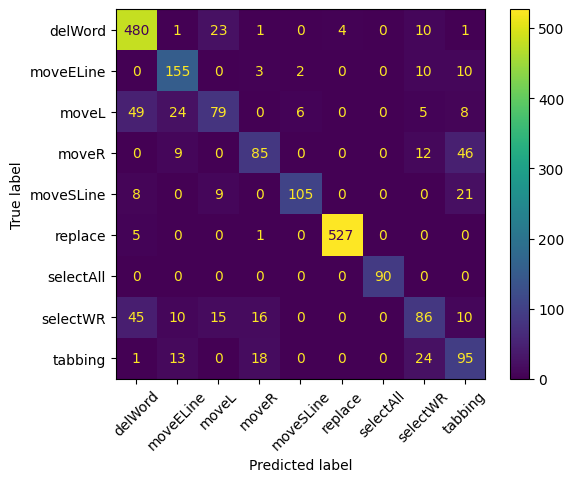

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Used to calculate the confusion matrix
y_true = []
y_pred = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(Y))
disp.plot()
plt.xticks(rotation=45)
plt.show()


Accuracy avant:  0.8194886296689053
Accuracy après:  0.9905797101449275
pred restantes:  5520
pred supprimees:  2967
pourcentage restant:  0.6504065040650406


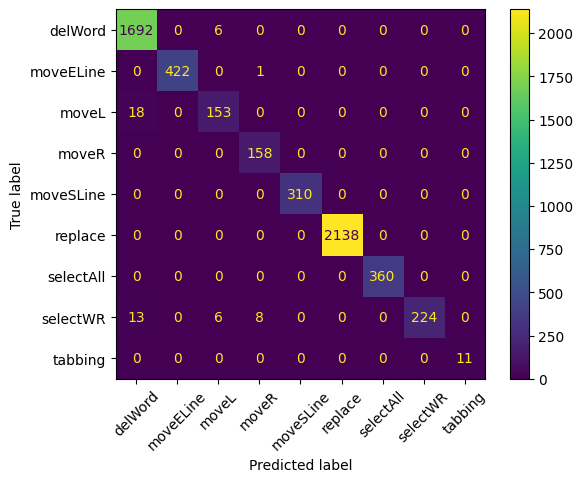

In [39]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in train_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.8
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

Accuracy avant:  0.8020735155513666
Accuracy après:  0.9749631811487481
pred restantes:  1358
pred supprimees:  764
pourcentage restant:  0.6399622997172478


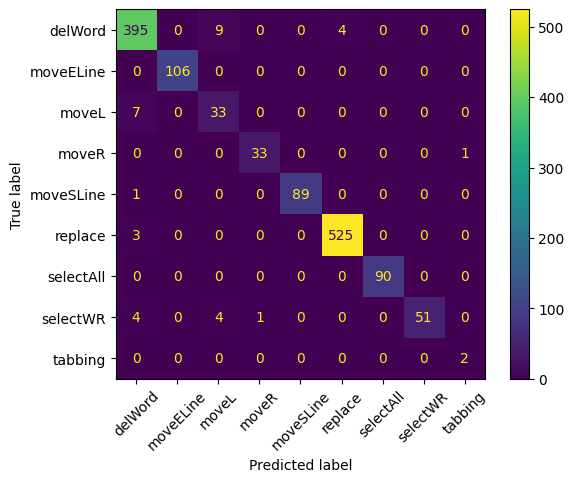

In [43]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.80
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

In [44]:
torch.save(model.state_dict(), "./models/model")